In [1]:
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.linalg import qr
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit, RawFeatureVector
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers import COBYLA, SPSA, QNSPSA, SLSQP, ADAM
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

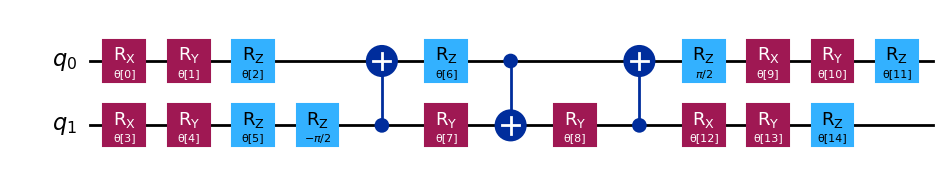

In [2]:
# We now define a two qubit unitary as defined in [3]

# Making matrices
matrix = np.random.normal
n = 2
H = np.random.randn(n, n)
Q, R = qr(H)
matrix0 = Q.dot(Q.T)
H = np.random.randn(n, n)
Q, R = qr(H)
matrix1 = Q.dot(Q.T)

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rx(params[0], 0)
    target.ry(params[1], 0)
    target.rz(params[2], 0)
    target.rx(params[3], 1)
    target.ry(params[4], 1)
    target.rz(params[5], 1)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[6], 0)
    target.ry(params[7], 1)
    target.cx(0, 1)
    target.ry(params[8], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    target.rx(params[9], 0)
    target.ry(params[10], 0)
    target.rz(params[11], 0)
    target.rx(params[12], 1)
    target.ry(params[13], 1)
    target.rz(params[14], 1)
    return target

# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=15)
circuit = conv_circuit(params)
circuit.draw("mpl")

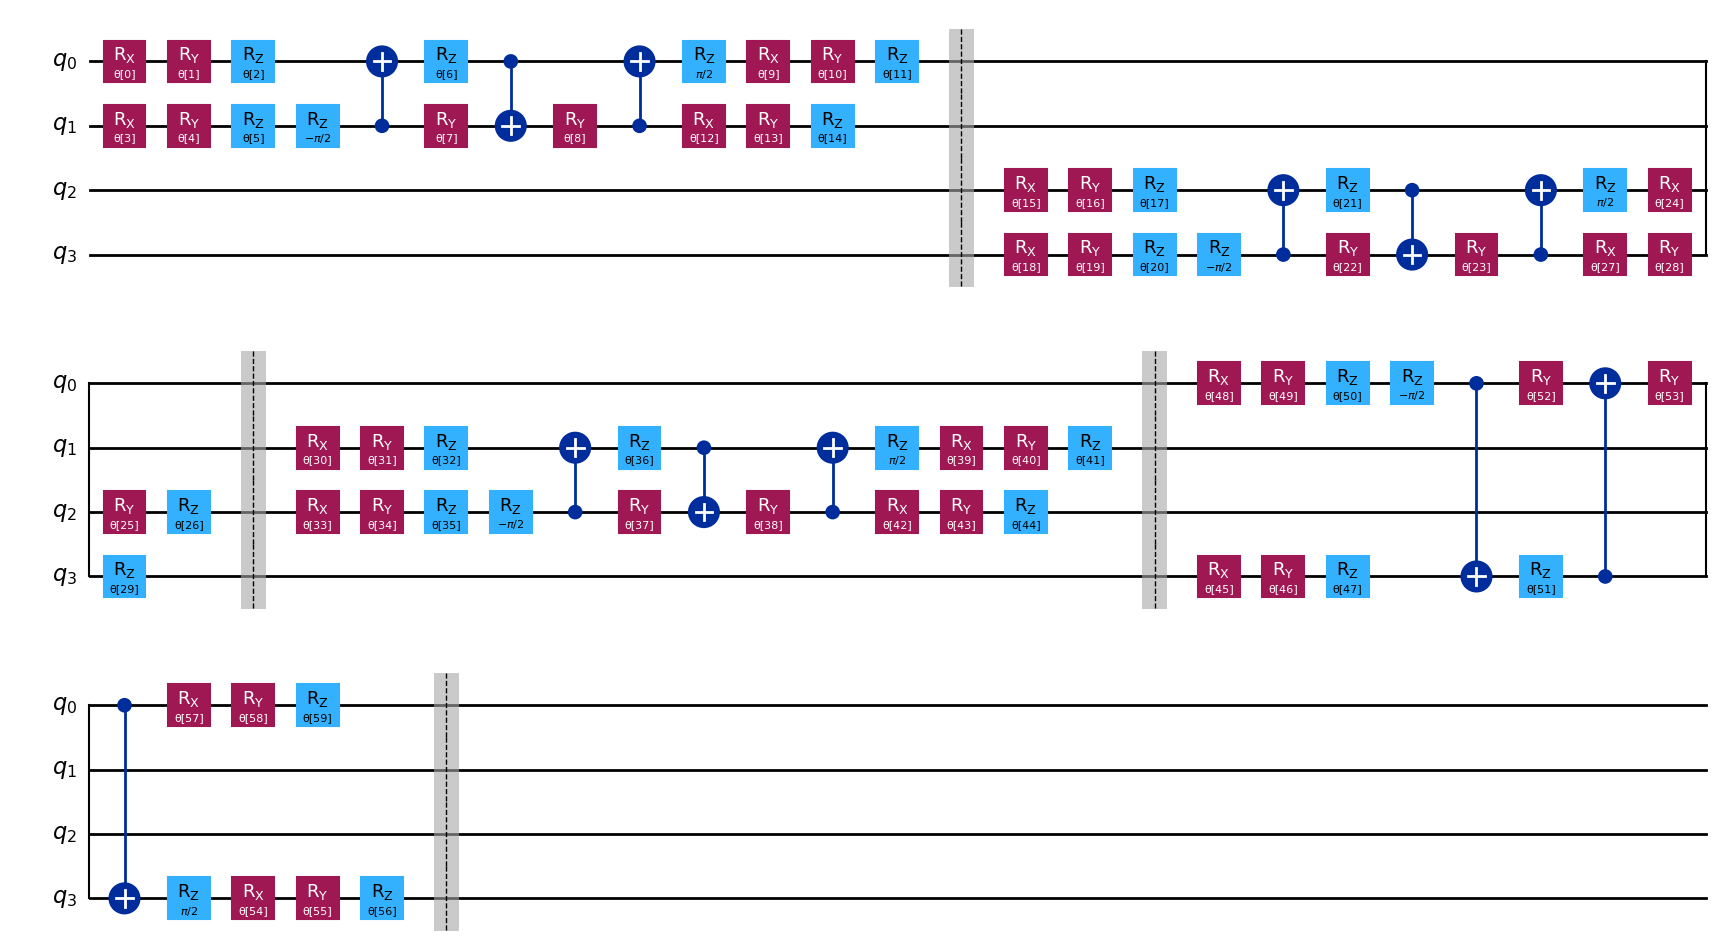

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

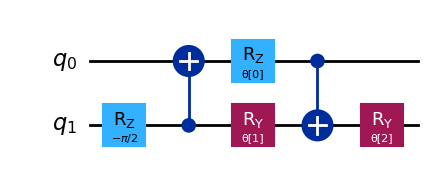

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

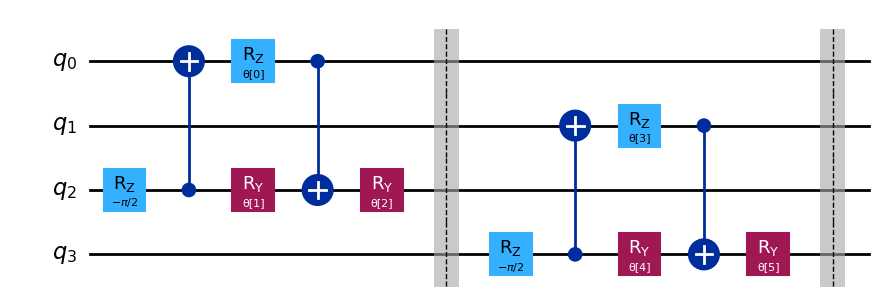

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [6]:
import tensorflow as tf
import collections
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [7]:
def filter_3649(x, y):
    keep = (y == 1) | (y == 2) | (y == 4) | (y == 0)
    x, y = x[keep], y[keep]
    # y = y == 3
    return x,y

In [8]:
x_train, y_train = filter_3649(x_train, y_train)
x_test, y_test = filter_3649(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 24465
Number of filtered test examples: 4129


0


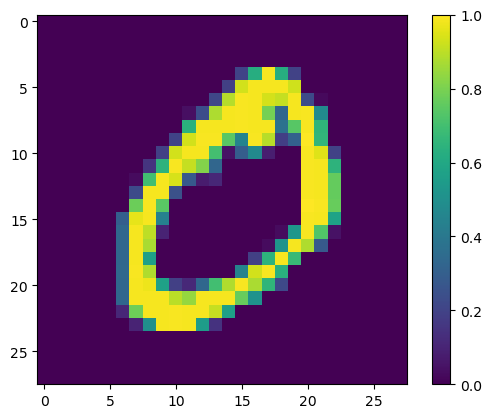

In [9]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [10]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

0


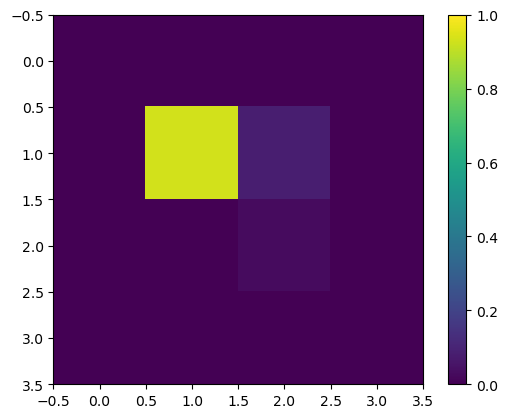

In [11]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [12]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and 1 in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and 2 in value)
    num_uniq_4 = sum(1 for value in mapping.values() if len(value) == 1 and 4 in value)
    num_uniq_9 = sum(1 for value in mapping.values() if len(value) == 1 and 9 in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) >= 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 1s: ", num_uniq_3)
    print("Number of unique 2s: ", num_uniq_6)
    print("Number of unique 4s: ", num_uniq_4)
    print("Number of unique 9s: ", num_uniq_9)
    print("Number of unique contradicting labels: ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.asarray(new_x), np.asarray(new_y)

In [13]:
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 17179
Number of unique 1s:  1823
Number of unique 2s:  4872
Number of unique 4s:  5153
Number of unique 9s:  0
Number of unique contradicting labels:  580

Initial number of images:  24465
Remaining non-contradicting unique images:  16599
Number of unique images: 3215
Number of unique 1s:  444
Number of unique 2s:  906
Number of unique 4s:  932
Number of unique 9s:  0
Number of unique contradicting labels:  71

Initial number of images:  4129
Remaining non-contradicting unique images:  3144


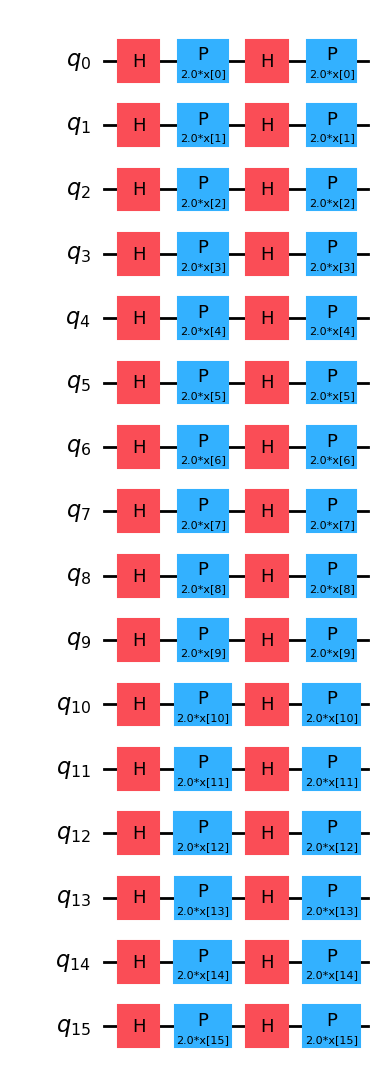

In [14]:
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

In [15]:
feature_map = ZFeatureMap(16)
ansatz = QuantumCircuit(16, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# # Fourth Convolutional Layer
# ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# # Fourth Pooling Layer
# ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 15, 1)])

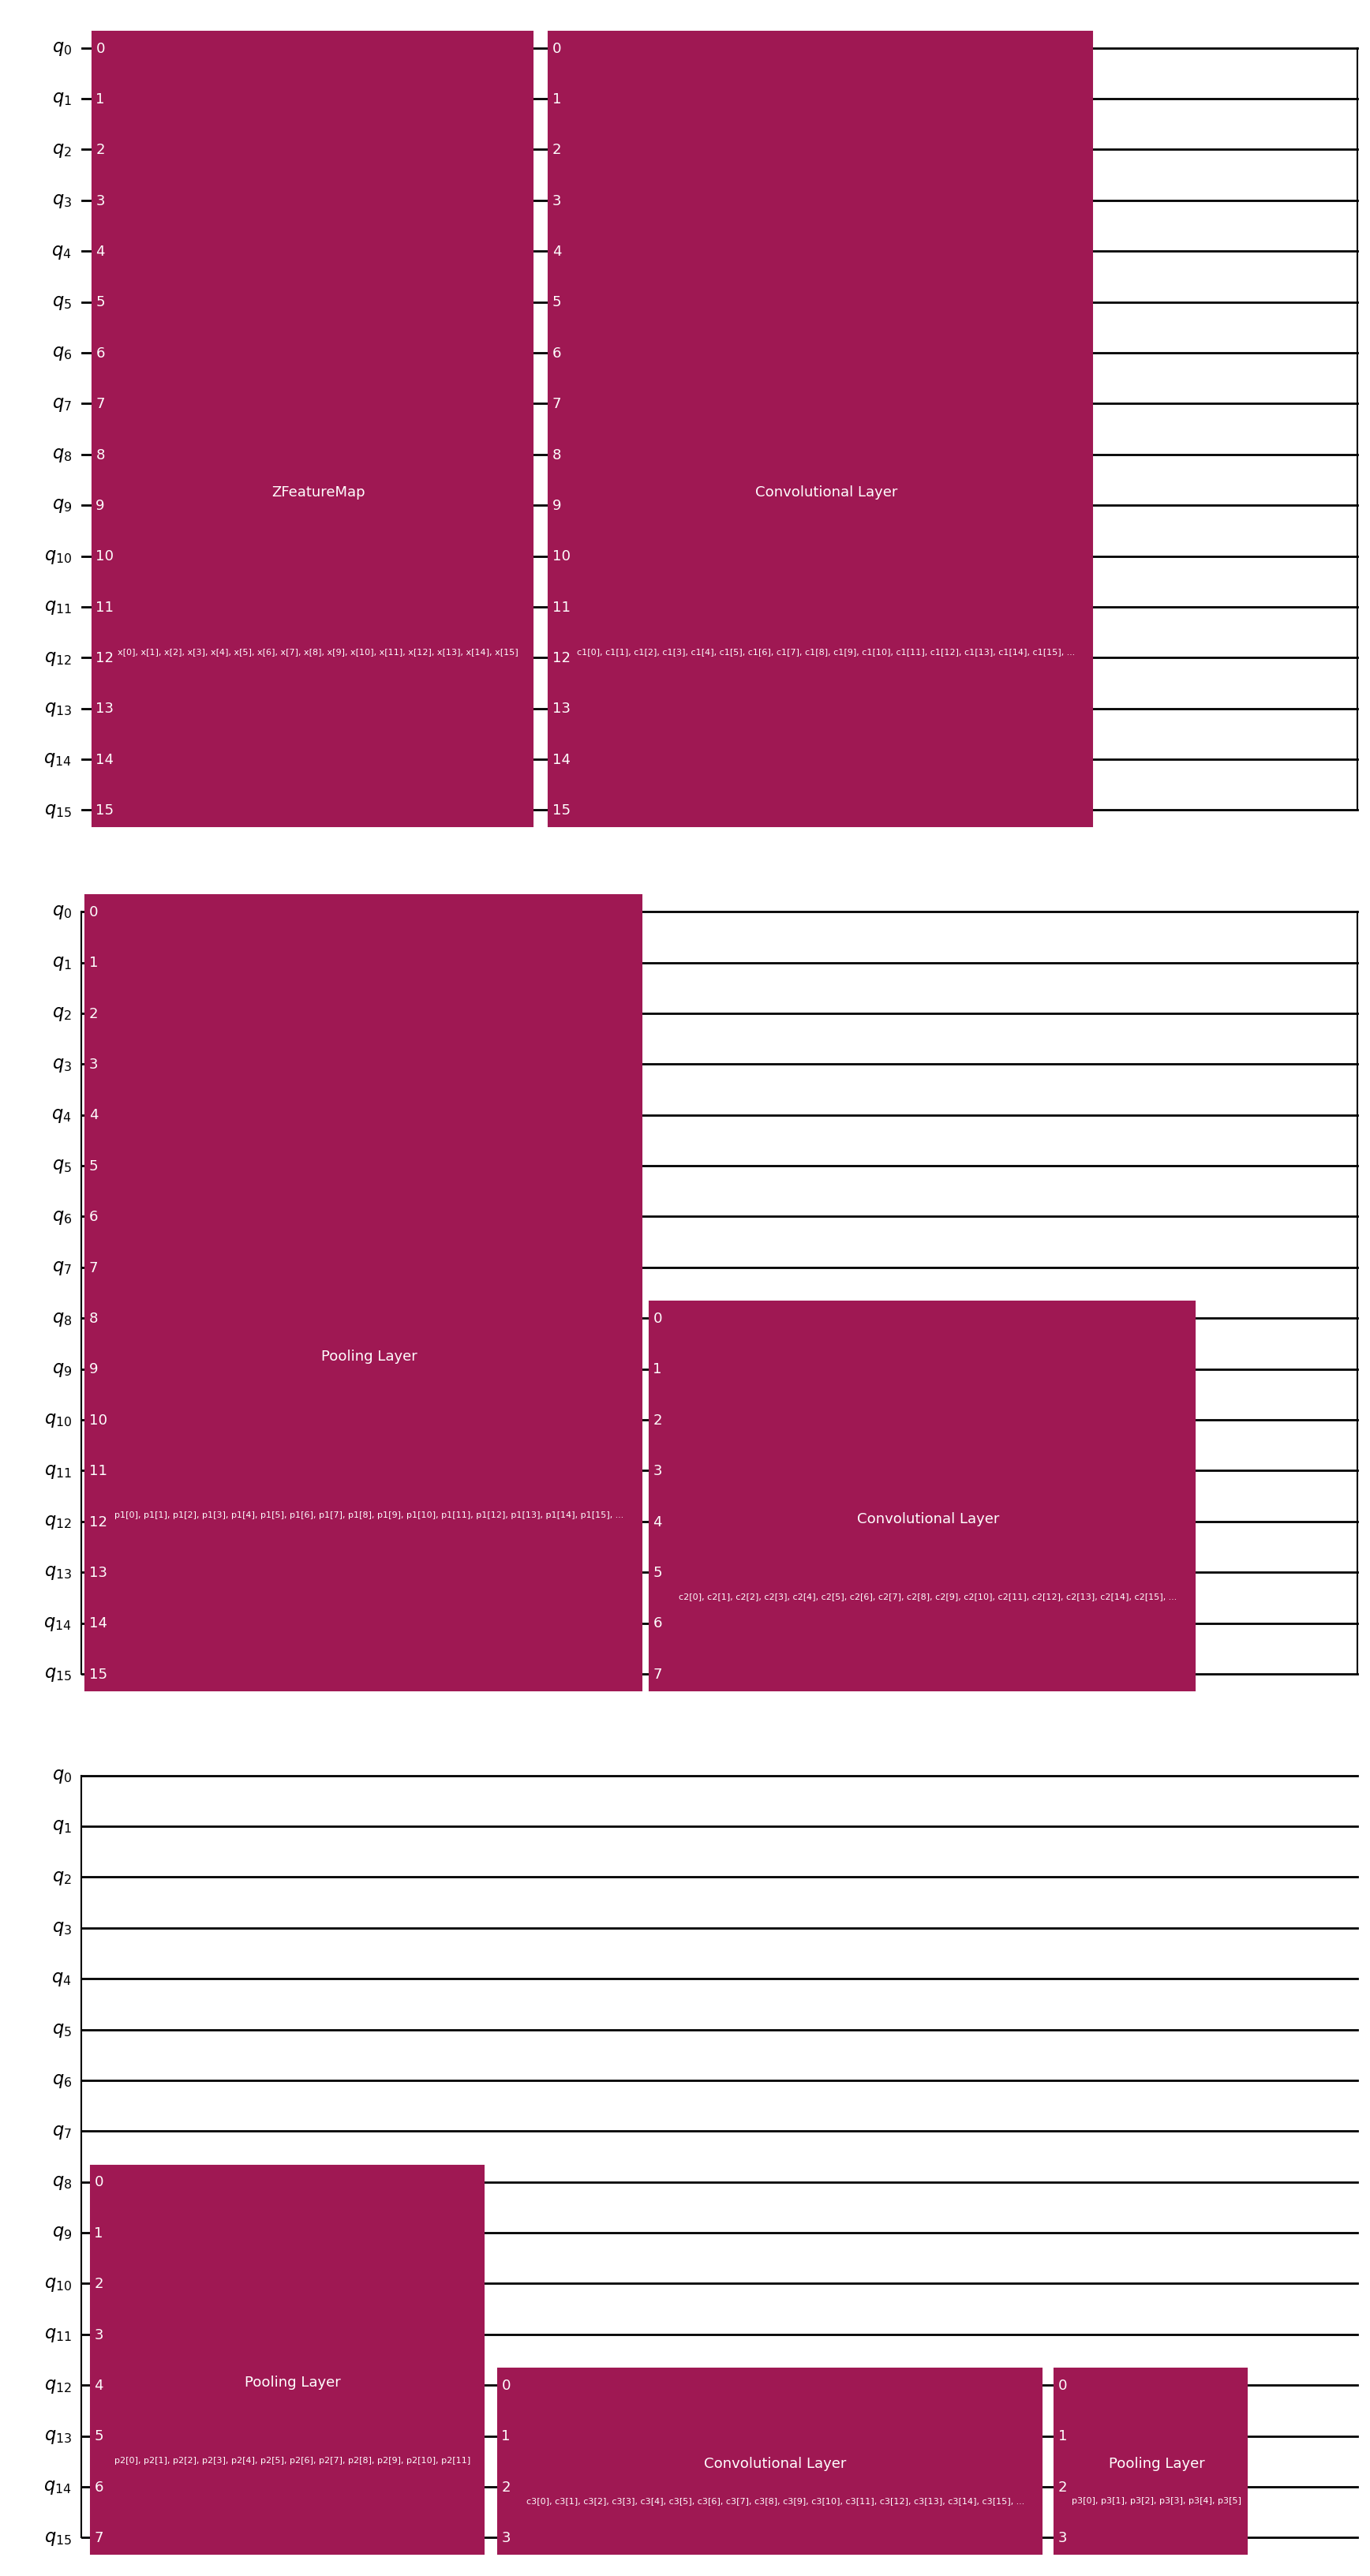

In [16]:
circuit.draw("mpl")

In [17]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    
  
    print("weights", weights)
    print("objective function value", objective_func_vals)
    
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [18]:
# construct variational quantum classifier
# weights = [-2.17502584e+00,-2.55499851e-01,2.87421105e-01,-2.00053816e+00
# ,1.76255455e+00,1.77038854e+00,-1.37533806e+00,1.24552744e+00
# ,2.28267037e+00,2.99371786e-01,-7.83548580e-01,-4.51928619e-02
# ,1.29710309e+00,1.01900849e-03,2.12697078e+00,2.38660524e+00
# ,2.76963964e-01,1.61141030e-01,9.89607647e-01,1.33188524e+00
# ,7.81821979e-01,-3.07880877e-01,2.60813975e+00,3.61865453e+00
# ,-1.01160567e+00,9.08154560e-01,-1.40325590e+00,-2.01164325e+00
# ,-4.25052633e+00,-1.62089604e+00,2.50282589e+00,3.84168615e+00
# ,-3.43920717e-01,-5.09435226e+00,-1.54116792e+00,9.10774762e-01
# ,2.62137133e+00,-4.39931620e-01,7.48571116e-01,-6.24691123e-01
# ,2.19074341e+00,9.26290563e-01,-6.88658714e-02,-2.12056864e+00
# ,-1.78051865e+00,6.56545129e-01,-2.41149682e-01,4.86340160e-01
# ,-2.83743145e+00,2.22006135e+00,1.43668201e+00,-1.56386973e+00
# ,-4.75949897e-01,-2.90429099e+00,3.74014778e+00,-3.19186516e+00
# ,1.07527580e+00,-2.04615018e+00,-2.45877284e+00,-3.58733162e+00
# ,1.72643059e+00,-8.80242148e-01,7.69950381e-01,-1.91904676e+00
# ,-2.69690913e+00,-1.16812747e+00,2.21521322e+00,-1.19044685e+00
# ,5.50897740e-01,-1.43943513e+00,2.93850677e-01,1.44159644e-01
# ,9.88382966e-03,-4.23080627e-01,2.93105227e+00,1.35977918e+00
# ,-1.92847364e-01,-1.24391171e+00,5.47813101e-01,-2.25809239e+00
# ,1.84415928e+00,-1.71371813e+00,2.03227860e+00,2.47259797e+00
# ,2.34146954e+00,-5.93055655e-01,3.09954623e+00,3.00783863e-01
# ,4.01229903e+00,1.32510027e+00,7.93757223e-01,3.58047050e-01
# ,-1.59742826e+00,1.35131872e+00,1.54350087e+00,3.07214673e+00
# ,3.34323840e-01,7.36738296e-01,2.42733697e+00,-7.87200506e-01
# ,-2.98892938e+00,-1.68899696e+00,-7.08010272e-01,-9.15076063e-01
# ,-9.50179339e-01,-2.14008652e+00,1.91312442e+00,2.06933346e+00
# ,1.03154794e+00,1.29353453e+00,1.21324804e+00,1.01370458e+00
# ,-1.16965310e+00,1.22229576e+00,1.17891421e+00,-1.07714379e+00
# ,-1.36794150e-01,1.03464002e+00,-5.21996767e-01,8.56653015e-01
# ,-1.77986190e+00,-8.49058232e-01,-2.78767456e-01,-2.05394334e-01
# ,4.70690688e+00,2.22801907e+00,-2.30822381e+00,2.90615411e+00
# ,-9.85416031e-01,4.22607882e+00,7.26991770e-01,1.49268485e+00
# ,-7.07112838e-01,1.21283112e+00,-1.32117364e+00,-4.05264693e+00
# ,-1.12995270e+00,1.22255232e+00,-2.56883150e+00,-2.72624983e+00
# ,-8.45107522e-01,2.47466745e-01,-1.03252792e+00,-3.59436185e-01
# ,-1.23139271e+00,3.15272390e+00,2.06732443e+00,2.77721750e+00
# ,-1.46218550e+00,-1.64966596e+00,2.16816694e-01,4.09851668e+00
# ,1.14356537e+00,-4.38937170e+00,3.16005601e+00,1.00189656e+00
# ,6.29764706e-01,-1.50263857e+00,-1.41365492e+00,-8.60697555e-01
# ,7.92607565e-01,1.25728974e+00,1.04783725e+00,-3.40500603e+00
# ,2.31041429e+00,-1.41315252e+00,1.73299699e+00,2.09968362e+00
# ,6.70889424e-01,7.14407369e-01,2.53982302e+00,-9.12572869e-01
# ,-1.73515996e+00,-1.86154450e+00,-3.63054870e-01,1.21198713e+00
# ,1.11622743e+00,-1.16949999e-01,-2.10424454e+00,-1.87399762e+00
# ,1.28250700e+00,1.41995961e+00,-9.87821599e-01,1.16583032e-01
# ,2.83403012e+00,-6.43915983e-01,3.01911172e-01,2.04201679e+00
# ,4.15928073e-01,2.13452595e+00,6.57711787e-01,-3.65409699e-01
# ,2.41009215e+00,3.85911115e+00,-1.77942597e+00,6.74642741e-02
# ,-1.61812415e+00,4.82842451e+00,2.99255565e+00,-1.03284284e+00
# ,3.44054878e+00,1.45734921e+00,1.38101046e+00,-7.01591901e-01
# ,9.50818045e-01,1.04773912e+00,-9.31518631e-01,-6.27703562e-01
# ,6.07402269e-01,-4.85463961e-01,-1.59531358e+00,1.17557625e+00
# ,2.97752700e+00,3.86175095e+00,-1.32039252e+00,1.15058181e+00
# ,2.13222967e+00,3.47331337e+00,4.20442898e-01,-2.69663567e-01
# ,3.04088172e+00,3.86351485e-01,2.24667104e+00,-2.46109382e+00
# ,-7.23013087e-01,7.64976252e-02,-1.13803217e+00,-2.66015601e-01
# ,3.43529114e+00,2.28879677e+00,1.53565726e+00,2.53089045e+00
# ,-8.98339117e-01,-1.16250990e+00,3.62730747e+00,3.82465861e-02
# ,8.91565130e-01,-2.72382298e+00,2.10698542e+00,1.01210993e+00
# ,1.82326216e+00,6.23260647e-01,2.58851419e-01,1.54167746e+00
# ,2.62942328e+00,1.46834998e+00,1.26907875e+00,-7.83070759e-01
# ,2.20957493e+00,-1.23120905e+00,2.66335948e+00,-1.63460337e+00
# ,1.50270360e+00,-8.21137000e-01,6.16468055e-02,-2.37603092e+00
# ,6.14747944e-01,-4.12649317e+00,3.48338947e+00,-1.62153611e+00
# ,1.10235168e+00,2.36131056e+00,-2.00120454e-01,3.29754736e-01
# ,-2.98668093e+00,-3.20429224e+00,7.88982522e-01,3.00525546e-01
# ,1.90440543e+00,-2.37735291e+00,1.25618587e+00,1.57046766e+00
# ,2.88691028e+00,1.01465349e+00,2.55217734e+00,1.29719798e+00
# ,1.03214263e+00,-4.67988028e-01,2.00759048e+00,2.00349011e+00
# ,3.68965578e-01,-1.12569969e+00,-3.63331685e-02,1.83387364e+00
# ,7.20405140e-01,1.36802118e+00,3.07978174e-02,-1.01986318e+00
# ,2.83316053e+00,-6.95179620e-01,-1.29932835e+00,-5.17587896e-01
# ,-2.53561248e-01,1.81344599e+00,1.37660433e+00,2.10727846e-01
# ,1.97106031e+00,1.86696941e+00,1.46542219e+00,2.46744122e-01
# ,1.74999523e+00,2.92966422e-01,-1.28043331e+00,-7.12221928e-01
# ,3.28466144e-01,3.98678831e+00,5.15017814e-01,-5.08597720e-01
# ,3.57626923e+00,2.50301845e+00,-1.27909434e+00,2.23403425e+00
# ,9.74947101e-01,1.85899471e+00,1.99749544e+00,-1.77921072e+00
# ,8.50242105e-01,2.70518574e+00,1.08945254e+00,1.50735783e-02
# ,1.68270007e+00,1.35669178e+00,-1.94241965e-01,2.50754325e-01
# ,-2.43143503e+00,-6.14694362e-01,-7.93727541e-01,1.04900327e+00
# ,-1.70658950e+00,-9.02226764e-01,-1.30051953e+00,2.80426642e+00
# ,3.59448211e+00,2.92626183e+00,1.98661131e+00,-3.85153800e+00
# ,1.07453801e+00,5.72089327e+00,3.16063585e+00,3.45458876e+00
# ,-3.19788875e-01,1.74069166e-01,3.66110280e+00,2.40043910e-02
# ,2.81172902e-02,4.14608662e+00,1.44011940e+00,2.75859778e+00
# ,3.78322619e+00,1.17308174e+00,-1.76382399e+00,1.03458876e-01
# ,2.48537371e+00,1.93984588e+00,2.95414419e+00,5.21609556e-01
# ,-7.01470841e-01,-2.25184340e-01,1.39241097e+00,2.97924432e+00
# ,2.22219565e-01,-4.15699576e-01,1.58721188e+00,-8.15643411e-01
# ,-1.16982097e+00,7.34279047e-02,1.05714477e+00,-1.50952753e-01
# ,2.32777552e-01,9.58176474e-01,8.47979006e-01,1.78557863e+00
# ,8.74128939e-01,-7.73255203e-01,4.64909388e+00,2.00584102e+00
# ,-1.08598295e+00,-1.79113433e-01,-1.68184374e+00,-1.72195076e+00
# ,7.25407708e-01,2.32264776e+00,-1.44093075e+00,1.62659811e+00
# ,-2.77707157e-02,-9.13371746e-01,-8.24847773e-01,2.10265368e+00
# ,2.05256553e+00,5.60359125e-01,-1.11242756e+00,9.76571940e-01
# ,-1.21867211e+00,9.02194810e-01,1.50177964e+00,-2.84839292e-01
# ,1.30622630e+00,2.49534169e-01,-1.12451887e-01,-4.12275362e+00
# ,-2.04686264e+00,8.00061582e-01,2.35064188e-01,-2.12414160e-01
# ,-1.67993556e+00,2.66260373e+00,2.23645615e+00,2.21180486e+00
# ,-1.31127389e+00,-1.17011650e+00,-1.78784374e+00,2.38161836e+00
# ,-2.42887110e+00,-5.84878456e-01,2.15978507e-02,1.03579921e+00
# ,4.56878497e+00,-1.49222669e-01,-6.44010128e-01,1.55757682e+00
# ,4.20072402e-01,-2.67601974e-01,4.39625038e+00,-3.02428020e-01
# ,1.32957997e-01,5.35526062e-01,-1.16605135e+00,1.39223692e+00
# ,1.75236030e+00,-3.80056911e-01,-1.97876846e+00,-6.42094594e-01
# ,-1.15351566e+00,5.11518289e+00,1.57142146e+00,-1.91900246e-01
# ,3.78161608e-01,2.33230744e+00,-6.49708643e-01,-2.61639650e+00
# ,3.54037846e-02,7.55507597e-01,-1.94887792e+00,-3.41240081e+00
# ,2.34820925e+00,3.56923764e+00,-1.43487107e+00,3.75016786e+00
# ,1.56843474e+00,2.55436490e+00,2.22658883e+00,1.42650502e+00
# ,-2.29931840e+00,2.39982140e+00,1.82371885e+00,1.54248603e+00
# ,4.11167460e+00,-2.60256992e+00,1.36700599e-01,-1.86122684e-02
# ,3.29034475e+00,8.68468851e-01,2.80040717e+00,1.36839726e+00
# ,4.22487988e-01,-3.37502901e+00,4.91602310e-01,-1.60201081e+00
# ,-6.37319240e-01,2.30604944e+00,2.13353858e+00,-1.64284790e-01
# ,-1.24310111e+00,-1.06444749e+00,-2.26111989e+00,1.54235084e+00
# ,3.86624736e-01,4.74859383e-01,5.73726150e-01,1.65516543e+00
# ,3.60343767e+00,1.61644375e+00,-4.97027229e-02,4.05301388e+00
# ,-1.35863499e+00,1.01277202e+00,-2.60888410e+00,-1.52560228e+00
# ,-8.96638026e-01,1.51552907e+00,1.49903812e+00,3.08854081e-01
# ,-2.86707714e-01,-3.84719620e+00,-1.05259652e+00]

weights = [2.08713408e+01,9.69442426e-01,2.06494753e+01,2.03016238e+01
,8.38673732e-01,5.91347668e-01,1.86835653e+00,2.15726074e+01
,5.35566810e-01,1.02724726e+00,7.66485468e-01,1.76930374e+00
,1.15558349e-01,5.60979716e-01,7.70304514e-01,5.10305683e-01
,1.81970714e-01,9.96455077e-02,9.03654103e-01,7.13858530e-01
,3.81401593e-01,2.24001140e-01,3.17102724e-01,3.68597993e-01
,4.79552292e-01,1.28201698e-01,8.86695711e-01,6.98318152e-01
,8.10926111e-01,6.81025099e-01,4.05816270e-01,9.95904230e-03
,2.42555762e-02,7.06494904e-01,4.80815891e-01,9.08096550e-02
,1.83550847e-01,8.67463660e-01,7.89718793e-03,5.23676210e-01
,4.83620087e-01,1.42242154e-01,5.86965447e-01,3.46898045e-01
,1.72047730e-01,4.25815796e-01,4.47743980e-01,1.21138523e+00
,1.95158692e+00,3.25970366e-01,6.31133238e-02,6.94112841e-01
,3.42171169e-01,3.62972489e-01,1.65090763e-01,3.28341676e-01
,7.33638678e-01,3.57879283e-01,6.31370438e-01,8.26089957e-01
,7.16214502e-01,2.02936973e-01,5.23099165e-02,6.96915759e-01
,1.03508971e-01,6.06925412e-01,9.13982098e-02,1.14591331e-01
,2.52012917e-01,9.63696757e-01,4.19835306e-01,7.84639901e-01
,2.16006146e-01,2.30343637e-01,7.80622010e-01,9.49516422e-02
,3.92230113e-01,4.20016449e-01,4.74021934e-01,9.34243640e-01
,5.71833171e-02,1.50290763e-01,5.25027831e-01,5.29635049e-01
,4.20129599e-02,7.04146275e-01,6.49464383e-01,4.40471533e-01
,9.34868406e-02,8.47444906e-01,7.22613442e-01,6.90302526e-01
,7.52876130e-01,4.13134986e-02,4.77260120e-01,4.80581957e-01
,8.38911532e-01,6.48595940e-01,3.20456449e-01,6.45069288e-01
,3.38224545e-01,1.38119904e-01,3.53391372e-01,9.15791753e-02
,5.01141220e-01,5.09925867e-01,1.78963246e-01,8.97796373e-04
,6.99780082e-01,9.58105505e-01,7.61130600e-01,8.07363210e-02
,7.10834150e-01,3.68351482e-01,9.84709644e-01,9.21112268e-01
,8.44173091e-01,5.10679238e-01,6.94451057e-01,9.95754243e-01
,5.87682096e-01,8.74509153e-02,8.08771701e-01,6.54169132e-01
,9.10006472e-01,9.91258031e-01,2.63844356e-01,7.25236642e-03
,9.73872415e-01,2.19216492e-01,4.39770067e-01,7.81124781e-01
,1.25632165e-02,8.90434434e-01,8.90459239e-01,1.16424251e-01
,1.93670640e-01,3.74420901e-02,4.05237140e-01,3.30965051e-01
,5.54630748e-01,7.45286743e-01,4.37644940e-01,5.60380363e-01
,8.02178042e-01,3.34418168e-01,5.16413468e-01,1.19311625e-01
,1.78721235e-01,3.23156385e-01,7.74644336e-01,8.37013082e-01
,3.26678850e-01,3.61256099e-01,9.39704066e-01,5.57896919e-01
,5.77430956e-01,5.31225879e-01,4.24296499e-01,6.63552061e-01
,3.91647619e-01,1.87661753e-01,8.73535645e-03,7.65984431e-01
,7.14672605e-01,3.67435649e-01,6.58672998e-01,2.89352220e-01
,4.81398548e-01,9.66381311e-01,1.00523226e-01,2.79559888e-01
,9.00965751e-01,7.31045429e-01,6.47540285e-01,6.21504597e-01
,3.57847851e-01,7.86833666e-01,5.55043134e-01,2.56974676e-02
,2.91987249e-01,5.08576789e-01,5.01472890e-02,8.02315181e-01
,1.37218959e-01,9.75406777e-01,6.99186841e-01,1.73631908e-01
,4.77033043e-01,2.43269621e-01,9.78989285e-01,9.11104163e-01
,5.40078158e-01,1.75171507e-02,2.56138084e-01,6.83087751e-01
,8.07849767e-01,4.51961656e-01,8.06717619e-02,9.16042019e-01
,2.82928451e-01,4.86740529e-01,4.16291246e-01,1.78671802e-01
,3.04981607e-01,1.38797397e-01,8.73225448e-01,8.69136195e-01
,3.61594546e-01,9.80698234e-01,4.61686324e-01,6.14086844e-01
,6.79519619e-01,1.77819586e-01,6.26772594e-02,2.55353927e-01
,3.10111974e-01,3.60341134e-01,9.28054467e-01,8.36517523e-01
,3.17231084e-01,2.24897328e-01,1.42884813e-01,9.64642142e-01
,7.99896899e-01,3.23919578e-01,2.50822312e-01,6.98822209e-01
,7.05892439e-01,5.61837822e-01,4.85767691e-02,2.57543880e-01
,3.77909365e-01,7.38248335e-01,7.49530751e-01,6.57926250e-01
,9.15088151e-01,7.61467726e-01,5.46076142e-01,3.92912526e-01
,8.81942382e-01,6.68322270e-01,9.57136440e-01,3.79161198e-01
,4.40675647e-01,6.84309872e-01,8.62593385e-01,2.15752638e-01
,8.43722397e-01,9.38086084e-01,3.84613185e-02,6.47350318e-01
,7.90091858e-02,2.76987651e-01,6.39618155e-01,8.65124052e-01
,3.60785497e-01,5.13444918e-01,7.98050076e-01,7.50598825e-01
,9.12018522e-01,1.38627060e-01,8.81285639e-01,4.97857438e-01
,8.75855734e-01,6.91811106e-01,3.74970997e-01,9.16085809e-01
,2.85619691e-03,2.68728916e-01,4.76075361e-01,1.09152718e-01
,2.81789874e-02,4.21123727e-01,6.82529104e-01,4.05563484e-01
,5.50159528e-01,2.02122291e-01,9.97297549e-01,8.00891323e-01
,4.98946907e-01,9.74772983e-01,2.34917028e-01,5.54115388e-01
,2.07241859e-01,1.43033542e-01,1.72808933e-02,6.17434296e-01
,7.59083807e-01,5.03761433e-01,7.46247999e-01,2.00243851e-01
,9.43347527e-01,9.28844994e-01,1.42821649e-01,3.70438765e-01
,3.49062725e-01,2.51276380e-01,7.59617383e-01,3.05026555e-01
,9.96064529e-01,6.18375778e-01,5.18180457e-01,4.52564100e-01
,2.00089869e-01,6.73638371e-01,9.51113027e-01,3.14038825e-02
,4.45942891e-01,3.33918708e-02,7.40978875e-01,8.30967522e-01
,5.77130038e-01,6.72672674e-01,6.91033306e-01,6.07881490e-01
,3.67029300e-01,1.59710505e-01,8.48123335e-01,3.28286297e-01
,2.84725716e-01,2.34602001e-01,9.09859613e-01,5.01405009e-01
,8.39723055e-01,9.22705418e-01,9.60365446e-01,5.34967716e-02
,8.15947352e-01,2.47514091e-01,1.33299185e-01,3.16078371e-01
,2.57508001e-01,2.50103278e-01,2.28674113e-01,9.47266122e-01
,5.44529659e-03,7.27462191e-02,7.58036423e-01,4.19363722e-01
,9.54189807e-01,7.38777602e-01,9.49965020e-01,8.10222371e-01
,1.55912098e-01,7.12503905e-01,5.72203034e-01,4.70545476e-01
,1.92905552e-01,6.88174576e-01,7.58153500e-01,3.32931259e-01
,9.84761551e-01,3.25488480e-01,5.22895788e-01,3.37964919e-01
,9.84300807e-01,8.57248380e-01,9.74974804e-01,6.91021186e-01
,1.92831910e-01,7.39133913e-01,9.00494299e-01,8.50129523e-01
,6.48058260e-01,1.33772620e-04,8.69139920e-02,8.46603814e-01
,3.35244934e-01,1.85411447e-01,7.24326059e-01,3.47432774e-01
,5.34843684e-01,8.37033143e-01,3.49542294e-02,8.87437767e-01
,4.64174541e-01,4.97221885e-01,3.21066069e-01,7.90087499e-01
,6.74595788e-01,2.59478081e-01,7.51526880e-01,3.63451601e-01
,6.49644416e-01,9.60521249e-01,2.19017712e-01,5.95295109e-01
,3.36060224e-02,8.26454717e-01,3.99218686e-01,9.39882170e-01
,6.54553089e-01,6.73250871e-01,4.35344987e-01,1.88248993e-01
,9.63136087e-01,6.98458604e-01,7.65282962e-01,7.19175495e-01
,5.25149220e-03,3.93093538e-01,8.72593878e-01,2.02609567e-01
,6.32053801e-01,8.64070390e-01,2.49399442e-01,3.23712003e-01
,4.67087188e-01,8.44994375e-01,4.41094843e-01,7.44869508e-01
,5.33812868e-01,9.99731100e-01,9.45560767e-04,2.40194135e-01
,1.89224052e-01,5.49054315e-01,5.80672233e-01,9.04104486e-01
,5.07660233e-02,7.03670415e-01,4.11233999e-01,3.35837327e-01
,4.98207364e-01,7.86211668e-01,3.44479865e-01,2.48312946e-01
,3.00853957e-01,4.83822573e-01,2.16648071e-01,2.54558214e-01
,3.12703441e-01,5.23181939e-01,1.64847494e-01,8.12032676e-02
,6.17284116e-01,9.85046161e-02,7.15370638e-01,3.82451567e-02
,4.92825673e-01,3.66900409e-01,8.64758398e-01,8.92942423e-01
,5.98076267e-01,8.06652254e-01,8.75995961e-01,5.73681128e-01
,6.93731027e-01,2.51785502e-01,2.81921425e-01,4.78721347e-01
,7.05155281e-01,5.25420454e-01,5.32660289e-01,4.89443330e-01
,6.39395951e-01,9.65172816e-01,9.18913432e-02,2.64503706e-01
,8.62304943e-01,5.77180018e-01]

classifier = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=SPSA(maxiter=15),
    callback=callback_graph,
    warm_start = True,
    # initial_point = weights
)

In [19]:
# y_int = []
# for a in train_labels:
#     if a:
#         y_int.append(1)
#     else: 
#         y_int.append(-1)
        
# y1_int = []
# for a in test_labels:
#     if a:
#         y1_int.append(1)
#     else: 
#         y1_int.append(-1)

x_reshaped = []
x1_reshaped = []

for b in resized_train_images:
    x_reshaped.append(b.reshape(1,16))

for b in resized_test_images:
    x1_reshaped.append(b.reshape(1,16))

final_x = []
final_x1 = []

for entry in x_reshaped:
    #print("entry \n" , entry[0])
    final_x.append(entry[0])

for entry in x1_reshaped:
    #print("entry \n" , entry[0])
    final_x1.append(entry[0])

objective_func_vals = []

x = np.asarray(final_x)
y = np.asarray(train_labels)

x = x[:15]
y = y[:15]

print(x)
print(y)

# def convert_to_onehot(arr):
#     encoded_arr = np.zeros((arr.size, arr.max()+1), dtype=int)
#     encoded_arr[np.arange(arr.size),arr] = 1
#     print(encoded_arr)
# y = convert_to_onehot(y)

[[0.         0.         0.         0.         0.         0.93333334
  0.08235294 0.         0.         0.         0.02745098 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.18039216 0.
  0.         0.         0.         0.         0.6627451  0.
  0.         0.         0.3764706  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.99215686 0.         0.         0.1882353  0.         0.
  0.         0.99215686 0.         0.        ]
 [0.         0.         0.         0.         0.         0.9882353
  0.3019608  0.         0.         0.7058824  0.5058824  0.19215687
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.01176471 0.
  0.85490197 0.         0.         0.91764706 0.9882353  0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.9254902
  0.9529412  0.         0.         0.         0.         0.
  0.         0.

weights [ 0.47858466  0.87187437  0.37721307  0.35625293  0.44043014  0.78638707
  0.30241725  0.58060335  0.40709565  0.58235599  0.14777935  0.73321189
  1.17344134  0.42620903  0.26836727  0.73868253  0.44617173  0.08944902
 -0.12038679  1.16010014  0.67698587 -0.09267631  0.81597131  0.86551435
  0.28209668  0.16491508  0.29644405  0.49535638  1.01409638  0.26776517
  0.28937437  0.26783146  0.9912966   0.28367472  0.59898674  0.5920583
  0.45576194  1.03818162  0.2883     -0.19334021  0.30760463  0.4893898
  0.35982937  0.54015276  0.61013978  0.97213827  0.39067124  1.08814984
  0.45212293 -0.02236351  1.1475314   0.40974172  0.49280824  1.10228862
  0.60082585  0.62699932  1.06351452  0.60426609  0.00272546  0.40835413
  0.21578701  0.6098801   0.01656327  0.3638417   0.55535968  1.19375134
  0.47027585  0.98457988  0.57621268  0.54116925 -0.09240102  0.41820733
  0.32768743 -0.12818685  0.08209856  0.31559125  0.56769158  0.6994783
  1.00221951  0.94520001  0.27911011  0.084354

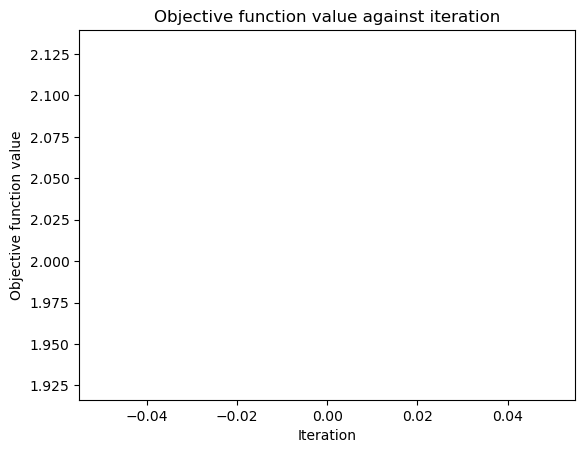

In [ ]:
classifier.fit(x, y)
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [21]:
x1 = np.asarray(final_x1)
y1 = np.asarray(test_labels)
        
x1 = x1[:50]
y1 = y1[:50]
y_predict = classifier.predict(x1)

print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")

Accuracy from the test data : 8.0%


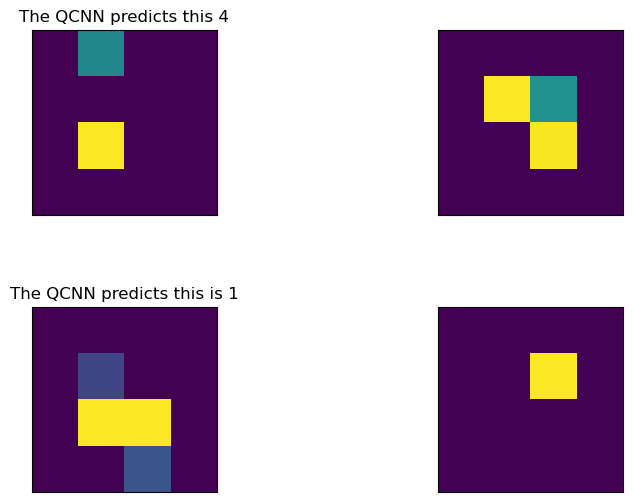

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 1")
    if y_predict[i] == 2:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 2")
    if y_predict[i] == 4:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 4")   
    # if y_predict[i] == 9:
    #     ax[i // 2, i % 2].set_title("The QCNN predicts this 9") 
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [23]:
y_predict

array([4, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 4, 0, 1, 1, 4,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 4, 0, 4, 1,
       1, 1, 4, 1, 0, 1], dtype=uint8)

In [28]:
classifier.fit_result.fun

2.0242778079790003